In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA, CUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), wrong dep version loaded (2), mismatched flags (14))


In [4]:
CUDA.allowscalar(false)

In [5]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
args = Args(use_cuda = true)

Args(0.0003, 128, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

# Static

In [8]:
x_in = random_symbols(args.rng, (1024, 10, 16)) |> gdev;

In [9]:
y_out = random_symbols(args.rng, (1024, 10, 16)) |> gdev;

In [10]:
import .PhasorNetworks: PhasorFixed

In [11]:
layer = Chain(
    #x -> x,
    PhasorFixed(1024 => 1024, soft_angle),)

Chain(
    layer_1 = PhasorFixed(
        layer = Dense(1024 => 1024, use_bias=false),  # 1_048_576 parameters
        bias = ComplexBias((1024,)),              # 2_048 parameters
    ),
)         # Total: 1_050_624 parameters,
          #        plus 0 states.

In [12]:
ps, st = Lux.setup(args.rng, layer) .|> gdev

((layer_1 = NamedTuple(),), (layer_1 = (ps_layer = (weight = Float32[0.03999645 -0.050390787 … -0.03505738 -0.03834864; 0.0057544755 0.05269876 … -0.0034123152 -0.006475543; … ; -0.015822388 -0.006579278 … -0.001790984 0.010609971; 0.04013447 -0.048627794 … 0.04237618 -0.044667974],), ps_bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), st_layer = NamedTuple(), st_bias = NamedTuple(), leakage = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], period = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),))

In [13]:
ps.layer_1

NamedTuple()

In [14]:
st.layer_1

(ps_layer = (weight = Float32[0.03999645 -0.050390787 … -0.03505738 -0.03834864; 0.0057544755 0.05269876 … -0.0034123152 -0.006475543; … ; -0.015822388 -0.006579278 … -0.001790984 0.010609971; 0.04013447 -0.048627794 … 0.04237618 -0.044667974],), ps_bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), st_layer = NamedTuple(), st_bias = NamedTuple(), leakage = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], period = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [15]:
import .PhasorNetworks: LuxParams

In [16]:
y, _ = layer(x_in, ps, st)

(Float32[0.6165312 0.4600313 … -0.048641227 -0.34813362; 0.8105188 0.07318959 … -0.70459646 -0.6350491; … ; 0.7670376 0.05104334 … 0.23161863 -0.89155346; 0.54765403 -0.2795318 … -0.5774854 -0.073643826;;; -0.39846593 0.8525476 … 0.103189975 -0.74230117; -0.7132936 0.9503844 … 0.02752174 -0.70329165; … ; -0.2776236 -0.72500414 … 0.20652048 0.057994533; 0.21817614 0.9625238 … 0.11358022 0.88683903;;; 0.87196976 -0.4501954 … -0.04702032 0.1566484; 0.6298974 -0.8487922 … -0.80809057 -0.94668126; … ; 0.91573066 0.81812257 … -0.24605326 -0.31364876; -0.8586053 -0.20496435 … -0.88085675 0.71660846;;; … ;;; -0.4739683 0.4320525 … -0.6242285 -0.972289; 0.89595556 0.29665086 … 0.22213931 -0.82813865; … ; 0.27158523 -0.08287827 … -0.30679595 -0.047099654; -0.31757686 -0.14476362 … -0.100267746 0.028298922;;; 0.21888454 -0.8553933 … 0.574081 0.52125645; -0.49359787 0.49988982 … 0.24286327 0.42515764; … ; -0.86658597 -0.19746825 … 0.70524985 -0.84653986; -0.91802883 0.6845385 … 0.11362853 0.304895

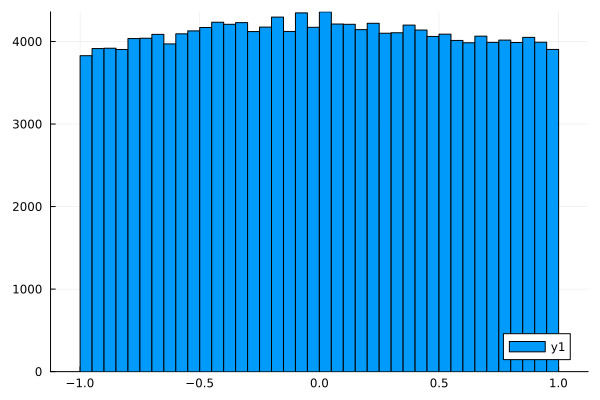

In [17]:
histogram(vec(cdev(y)))

# Dynamic

In [18]:
spk_args = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [19]:
xtrain = phase_to_train(x_in, spk_args=spk_args, repeats=10)

SpikeTrainGPU{3}(CartesianIndex{3}[CartesianIndex(1, 1, 1), CartesianIndex(2, 1, 1), CartesianIndex(3, 1, 1), CartesianIndex(4, 1, 1), CartesianIndex(5, 1, 1), CartesianIndex(6, 1, 1), CartesianIndex(7, 1, 1), CartesianIndex(8, 1, 1), CartesianIndex(9, 1, 1), CartesianIndex(10, 1, 1)  …  CartesianIndex(1015, 10, 16), CartesianIndex(1016, 10, 16), CartesianIndex(1017, 10, 16), CartesianIndex(1018, 10, 16), CartesianIndex(1019, 10, 16), CartesianIndex(1020, 10, 16), CartesianIndex(1021, 10, 16), CartesianIndex(1022, 10, 16), CartesianIndex(1023, 10, 16), CartesianIndex(1024, 10, 16)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  163831, 163832, 163833, 163834, 163835, 163836, 163837, 163838, 163839, 163840], Float32[0.4544829, 0.17357457, 0.6611862, 0.3216616, 0.66958964, 0.25858545, 0.1385169, 0.16643864, 0.033940017, 0.527015  …  9.648087, 9.936634, 9.15895, 9.695121, 9.635818, 9.749306, 9.575124, 9.838406, 9.41879, 9.57169], (1024, 10, 16), 163840, 0.0f0)

In [20]:
xc = SpikingCall(xtrain, spk_args, (0.0f0, 10.0f0))

SpikingCall(SpikeTrainGPU{3}(CartesianIndex{3}[CartesianIndex(1, 1, 1), CartesianIndex(2, 1, 1), CartesianIndex(3, 1, 1), CartesianIndex(4, 1, 1), CartesianIndex(5, 1, 1), CartesianIndex(6, 1, 1), CartesianIndex(7, 1, 1), CartesianIndex(8, 1, 1), CartesianIndex(9, 1, 1), CartesianIndex(10, 1, 1)  …  CartesianIndex(1015, 10, 16), CartesianIndex(1016, 10, 16), CartesianIndex(1017, 10, 16), CartesianIndex(1018, 10, 16), CartesianIndex(1019, 10, 16), CartesianIndex(1020, 10, 16), CartesianIndex(1021, 10, 16), CartesianIndex(1022, 10, 16), CartesianIndex(1023, 10, 16), CartesianIndex(1024, 10, 16)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  163831, 163832, 163833, 163834, 163835, 163836, 163837, 163838, 163839, 163840], Float32[0.4544829, 0.17357457, 0.6611862, 0.3216616, 0.66958964, 0.25858545, 0.1385169, 0.16643864, 0.033940017, 0.527015  …  9.648087, 9.936634, 9.15895, 9.695121, 9.635818, 9.749306, 9.575124, 9.838406, 9.41879, 9.57169], (1024, 10, 16), 163840, 0.0f0), Neuron parameters: Period 

In [21]:
y_s, _ = layer(xc, ps, st)

(SpikingCall(SpikeTrainGPU{3}(CartesianIndex{3}[CartesianIndex(1, 1, 1), CartesianIndex(2, 1, 1), CartesianIndex(3, 1, 1), CartesianIndex(4, 1, 1), CartesianIndex(5, 1, 1), CartesianIndex(6, 1, 1), CartesianIndex(7, 1, 1), CartesianIndex(8, 1, 1), CartesianIndex(9, 1, 1), CartesianIndex(10, 1, 1)  …  CartesianIndex(1015, 10, 16), CartesianIndex(1016, 10, 16), CartesianIndex(1017, 10, 16), CartesianIndex(1018, 10, 16), CartesianIndex(1019, 10, 16), CartesianIndex(1020, 10, 16), CartesianIndex(1021, 10, 16), CartesianIndex(1022, 10, 16), CartesianIndex(1023, 10, 16), CartesianIndex(1024, 10, 16)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  163831, 163832, 163833, 163834, 163835, 163836, 163837, 163838, 163839, 163840], Float32[2.0583377, 2.1379843, 1.7270133, 2.0417004, 2.2390273, 1.7189376, 1.4331853, 2.0140572, 1.781289, 1.7746724  …  10.700209, 11.04186, 10.877334, 10.832094, 10.830068, 10.943253, 11.081256, 10.545418, 11.15055, 10.724762], (1024, 10, 16), 163840, 0.25f0), Neuron parameters: 

In [22]:
size(y)

(1024, 10, 16)

In [23]:
size(y)

(1024, 10, 16)

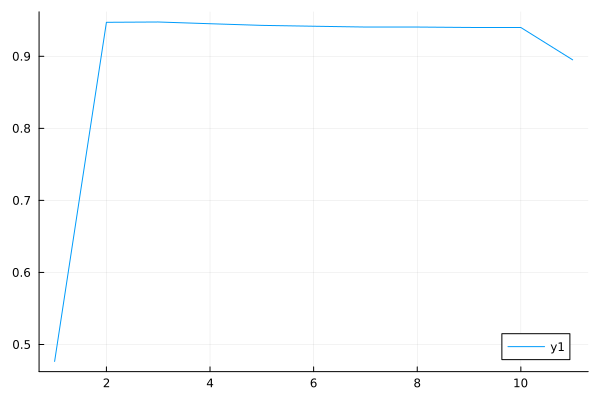

In [24]:
plot(cycle_correlation(cdev(y[:,:,1]), cdev(train_to_phase(y_s))[:,:,1,:]))

# Grads

In [25]:
layer2 = Chain(
    #x -> x,
    PhasorFixed(1024 => 1024, soft_angle, use_bias = true, trainable_leakage = true),)

Chain(
    layer_1 = PhasorFixed(
        layer = Dense(1024 => 1024, use_bias=false),  # 1_048_576 parameters
        bias = ComplexBias((1024,)),              # 2_048 parameters
    ),
)         # Total: 1_050_624 parameters,
          #        plus 0 states.

In [26]:
ps2, st2 = Lux.setup(args.rng, layer2) .|> gdev

((layer_1 = (leakage = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],),), (layer_1 = (ps_layer = (weight = Float32[0.011874189 -0.024496732 … -0.05242766 0.053805754; -0.0023277262 0.033014633 … 0.038601648 -0.04059573; … ; -0.006028986 0.041449625 … 0.032458708 0.012584829; -0.04960784 0.0016649881 … -0.03199932 -0.017595505],), ps_bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), st_layer = NamedTuple(), st_bias = NamedTuple(), period = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),))

In [27]:
y2, _= layer2(x_in, ps2, st2)

(Float32[-0.2703795 0.4967017 … 0.5791411 -0.19754766; -0.31450137 -0.06666874 … -0.11362563 0.296328; … ; 0.089135714 -0.3912873 … -0.387454 -0.21842995; -0.18963331 0.05749786 … 0.10482178 0.33679864;;; 0.2386836 0.0018849956 … -0.113515474 0.1668291; 0.5015161 0.16948225 … -0.14006005 0.00741892; … ; 0.3005792 0.29049894 … -0.14955156 0.18579724; -0.057327405 0.15997925 … -0.17085245 0.28120974;;; 0.48547563 -0.03893131 … 0.34685886 -0.24299718; -0.31463492 0.10928441 … -0.0558082 -0.34551528; … ; -0.15374127 0.36542976 … -0.09164126 -0.18068403; -0.16692199 -0.8826078 … 0.12537876 0.08178135;;; … ;;; -0.0005669367 -0.011615218 … 0.14697714 -0.23346092; 0.115734965 -0.11900045 … -0.17175633 0.50155544; … ; -0.3378237 0.18898663 … -0.76514745 -0.036304466; 0.32779586 -0.3295411 … 0.3879344 0.28992105;;; -0.7570276 -0.0014339983 … 0.5837139 0.5461105; 0.20720811 -0.106106 … 0.14458598 -0.013497697; … ; 0.10753754 -0.08375197 … -0.111168414 -0.1561804; -0.3125699 0.41246387 … -0.091942

In [28]:
y_s2, _ = layer2(xc, ps2, st2)

(SpikingCall(SpikeTrainGPU{3}(CartesianIndex{3}[CartesianIndex(1, 1, 1), CartesianIndex(2, 1, 1), CartesianIndex(3, 1, 1), CartesianIndex(4, 1, 1), CartesianIndex(5, 1, 1), CartesianIndex(6, 1, 1), CartesianIndex(7, 1, 1), CartesianIndex(8, 1, 1), CartesianIndex(9, 1, 1), CartesianIndex(10, 1, 1)  …  CartesianIndex(1015, 10, 16), CartesianIndex(1016, 10, 16), CartesianIndex(1017, 10, 16), CartesianIndex(1018, 10, 16), CartesianIndex(1019, 10, 16), CartesianIndex(1020, 10, 16), CartesianIndex(1021, 10, 16), CartesianIndex(1022, 10, 16), CartesianIndex(1023, 10, 16), CartesianIndex(1024, 10, 16)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  163831, 163832, 163833, 163834, 163835, 163836, 163837, 163838, 163839, 163840], Float32[1.6167462, 1.5937126, 1.8403413, 1.5882436, 1.573925, 1.73014, 1.2506998, 1.5988586, 1.9235212, 1.7559285  …  10.785253, 10.7226715, 10.71998, 10.747408, 10.624319, 10.603604, 10.8101015, 10.80183, 10.8276615, 10.636658], (1024, 10, 16), 163840, 0.25f0), Neuron parameters:

In [29]:
yp2 = train_to_phase(y_s2);

In [30]:
size(yp2)

(1024, 10, 16, 11)

In [31]:
size(x_in)

(1024, 10, 16)

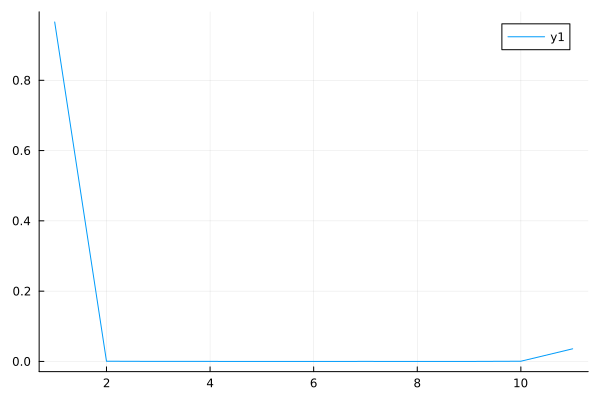

In [32]:
plot(cycle_sparsity(y2[:,:,1], yp2[:,:,1,:]))

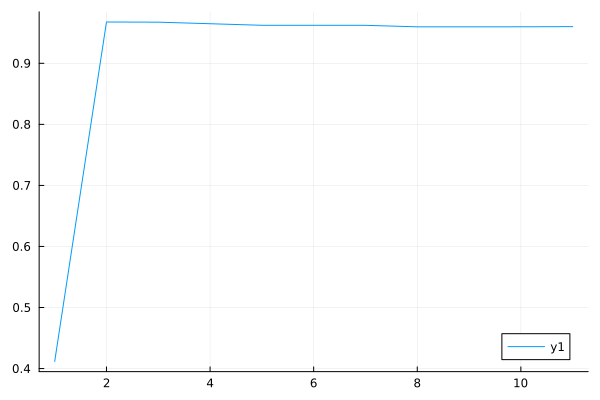

In [33]:
plot(cycle_correlation(cdev(y2[:,:,1]), cdev(train_to_phase(y_s2))[:,:,1,:]))

In [34]:
loss_fn = x -> abs(mean(x))

#1 (generic function with 1 method)

In [35]:
loss_fn(y2)

0.00035094464f0

In [36]:
loss_fn(layer2(x_in, ps2, st2)[1])

0.00035094464f0

In [37]:
withgradient(p -> loss_fn(layer2(x_in, p, st2)[1]), ps2)

(val = 0.00035094464f0, grad = (nothing,))

In [38]:
layer3 = Chain(
    #x -> x,
    PhasorFixed(1024 => 1024, 
                soft_angle,
                use_bias = true,
                trainable_leakage = true,
                return_type = PhaseSolution,),)

Chain(
    layer_1 = PhasorFixed(
        layer = Dense(1024 => 1024, use_bias=false),  # 1_048_576 parameters
        bias = ComplexBias((1024,)),              # 2_048 parameters
    ),
)         # Total: 1_050_624 parameters,
          #        plus 0 states.

In [39]:
psol, _ = layer3(xc, ps2, st2)

(CuArray{Float32, 3, CUDA.DeviceMemory}[[0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264; … ; 0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264;;; 0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264; … ; 0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264;;; 0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264; … ; 0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264;;; … ;;; 0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264; … ; 0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264;;; 0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264; … ; 0.04310

In [40]:
function loss_fn2(ps)
    st, _ = layer3(xc, ps, st2)
    p = st[end]
    return abs(mean(p))
end

loss_fn2 (generic function with 1 method)

In [41]:
loss_fn2(ps2)

0.0013326859f0

In [42]:
withgradient(loss_fn2, ps2)

LoadError: `llvmcall` requires the compiler